In [1]:
import os
import sys
import numpy as np 
import pandas as pd 
import math
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from seaborn import histplot

In [26]:
sys.path.append(os.path.expanduser("~") + "/Incoming/EagleKahnXylem")

In [31]:
from classification import encode_design_matrix

In [11]:
os.chdir(os.path.expanduser("~"))

In [3]:
if not os.path.exists("Data/Stocks"):
    !/opt/anaconda/miniconda/envs/default/bin/kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs
    !unzip -q price-volume-data-for-all-us-stocks-etfs.zip

In [4]:
files = [ os.path.join(dirname, filename) for 
         dirname, _, filenames in os.walk('Data/Stocks') for 
         filename in filenames ]
companies = [ os.path.basename(f).split(".")[0] for f in files ]

In [13]:
def volume(filename : str, log : bool = True) -> int:
    vol = []
    try:
        for v in pd.read_csv(filename)['Volume']:
            if log:
                vol.append(math.log(v))
            else:
                vol.append(v)
    except Exception:
        return []
    
    return vol

def max_volume(filename : str) -> int:
    try:
        return pd.read_csv(filename)['Volume'].max()
    except Exception:
        return None
    
def delta(filename : str) -> int:
    try:
        df = pd.read_csv(filename)
        return (df['High'] - df['Low']) / df['High']
    except Exception:
        return 0

def direction(filename : str) -> int:
    df = pd.read_csv(filename)
    w = (df['Open'] > df['Close'])
    result = pd.DataFrame()
    result['Date'] = df['Date']
    result['Gain'] = np.repeat(-1, len(df['Date']))
    result.loc[w, ('Gain')] = 1
    return result

def z(x : np.array, scale : dict):
    return ( x - scale['mean'] ) / scale['sd']

def build_company_daily_deltas(companies : list, files : list, z_transform : dict):
    for company, f in zip(companies[:3], files[:3]):
        yield pd.DataFrame({
            'date' : direction(f)['Date'],
            'company' : company,
            'delta' : delta(f),
            'direction' : direction(f)['Gain'],
            'rank': z(np.array(volume(f)), z_transform).round(2) }) 

  0%|          | 0/7195 [00:00<?, ?it/s]

  0%|          | 0/7195 [00:00<?, ?it/s]

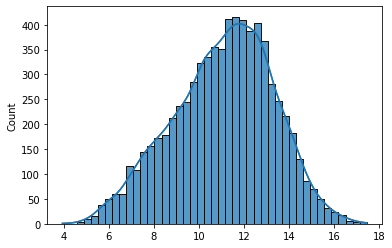

In [14]:
# build a median interest id based on trading volume that we can 
# use to post-stratify our input files
median_delta = pd.Series([ 
    np.median(delta(f)) for f in tqdm(files) ]).\
    interpolate(method='zero')
median_volume = pd.Series([ 
    np.median(volume(f)) for f in tqdm(files) ]).\
    interpolate(method='zero')
plot = histplot(median_volume, kde=True)
plot = histplot(median_volume, kde=True)

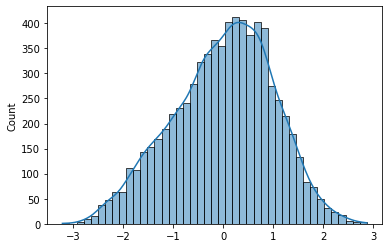

In [7]:
# build quantiles and a z-transform for identifying active 
# and not-so-active companies based on mdeian daily trading volumes
# that we can use to stratify our input data
transform = { 'mean': np.mean(median_volume), 'sd': np.std(median_volume) }
quantiles = np.quantile(median_volume, q=[0.0,0.2,0.5,0.8,1.0])
volume_rank = z(median_volume, transform).round(2)
plot = histplot(volume_rank, kde=True)

In [8]:
# builds a very large list of dataframe of daily deltas and ranks that we will use
# for later hierarchical modeling 
ranked_daily_deltas = build_company_daily_deltas(companies, files, transform)

In [17]:
# builds a data frame of macro deltas and volume ranks for each company
# to use for building strata using k-means clustering
macro_clusters = pd.DataFrame({
    'company':companies, 
    'delta': median_delta, 
    'vol_rank': volume_rank})

In [77]:
clusters = encode_design_matrix(
    macro_clusters, variables=['delta','vol_rank'], 
    normalize=False)
kmeans = KMeans(n_clusters=16,
    random_state=0).fit(clusters['x'])
macro_clusters['stratum'] = kmeans.predict(clusters['x'])

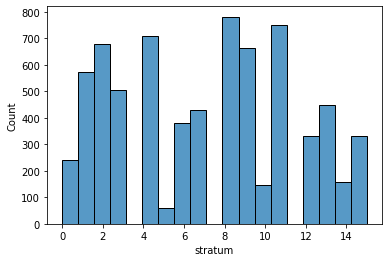

In [78]:
plot = histplot(macro_clusters['stratum'])

In [79]:
macro_clusters.head()

,company,delta,vol_rank,stratum
0,mhla,0.008575,-0.61,3
1,keg,0.051183,0.15,8
2,sptl,0.005836,0.15,8
3,rio,0.019782,1.75,14
4,rl,0.021392,1.22,7


In [ ]:
# for each company, fit a parametric model of closing price 
# and daily percent-change driven by annual and inter-annual 
# variation in time (year + julian day). We are going to partition-out
# the effect of company by pooling arbitrary companies into strata
# we derived from macro factor clusters (delta + volume)c